### Importing relevant libraries 

In [1]:
# Importing necessary libraries 
import time 
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import boto3
import botocore
import sagemaker
from sagemaker import get_execution_role
import os 

# Setting a seet to ensure code is reproducable 
np.random.seed(1)

### Initializing Sagemaker session/roles and S3 bucket locations

In [2]:
# Pointing to default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/DeepAR'
execution_role = sagemaker.get_execution_role()
region=boto3.Session().region_name

# Specifying code data locations and output directories 
dataset_location = f"{prefix}/original_dataset"  # Original dataset location
data_input = f"{bucket}/{prefix}/data"                    # Training and test file locations 
train_input = f"{prefix}/data/train"
test_input = f"{prefix}/data/test"
data_output = f"{bucket}/{prefix}/output"                 # Model output location 

# Returning S3 bucket values 
print(f"S3 Bucket: {bucket}", f"Prefix: {prefix}", f"Execution Role: {execution_role}", f"Region: {region}", 
      f"Dataset Location: {dataset_location}", 
      f"Training Data Directory: {train_input}", 
      f"Testing Data Directory: {test_input}", 
      f"Output Directory: {data_output}", 
      sep="\n")

S3 Bucket: sagemaker-us-east-1-981537519177
Prefix: sagemaker/DeepAR
Execution Role: arn:aws:iam::981537519177:role/service-role/AmazonSageMaker-ExecutionRole-20210707T184971
Region: us-east-1
Dataset Location: sagemaker/DeepAR/original_dataset
Training Data Directory: sagemaker/DeepAR/data/train
Testing Data Directory: sagemaker/DeepAR/data/test
Output Directory: sagemaker-us-east-1-981537519177/sagemaker/DeepAR/output


### Importing dataset from S3 Bucket 

In [3]:
# Function borrowed from AWS sample notebook with some modifications to the print outputs 
def check_bucket_permissions(bucket):
    permission = False 
    # Checks if a given s3 bucket exists with the bucket specified 
    try:
        boto3.Session().client('s3').head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(f"s3 bucket: {bucket} does not exist or was not provided.")
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "403":
            print(f"User does not have access to bucket: {bucket}")
        elif e.response['Error']['Code'] == "404":
            print(f"Bucket: {bucket} does not exist")
        else:
            raise
    # If no exceptions were raised then indicate that S3 bucket exists and user has access
    else:
        permission = True 
    return permission

# Function to download files from s3
def download_from_s3(bucket, files):
    s3 = boto3.resource('s3')
    for file in files:
        try:
            s3.Bucket(bucket).download_file(file, str(file_name))
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                print(f"Object {file} does not exist.")
            else:
                raise 
                
                
# Function to download files from s3
def download_from_s3_new(bucket, dataset_location, file_names):
    s3 = boto3.resource('s3')
    for fn in file_names:
        file = f"{dataset_location}/{fn}"
        file_name = str(fn)
        try:
            s3.Bucket(bucket).download_file(file, str(file_name))
        except botocore.exceptions.ClientError as e:
            if e.response['Error']['Code'] == "404":
                print(f"Object {file} does not exist.")
            else:
                raise 

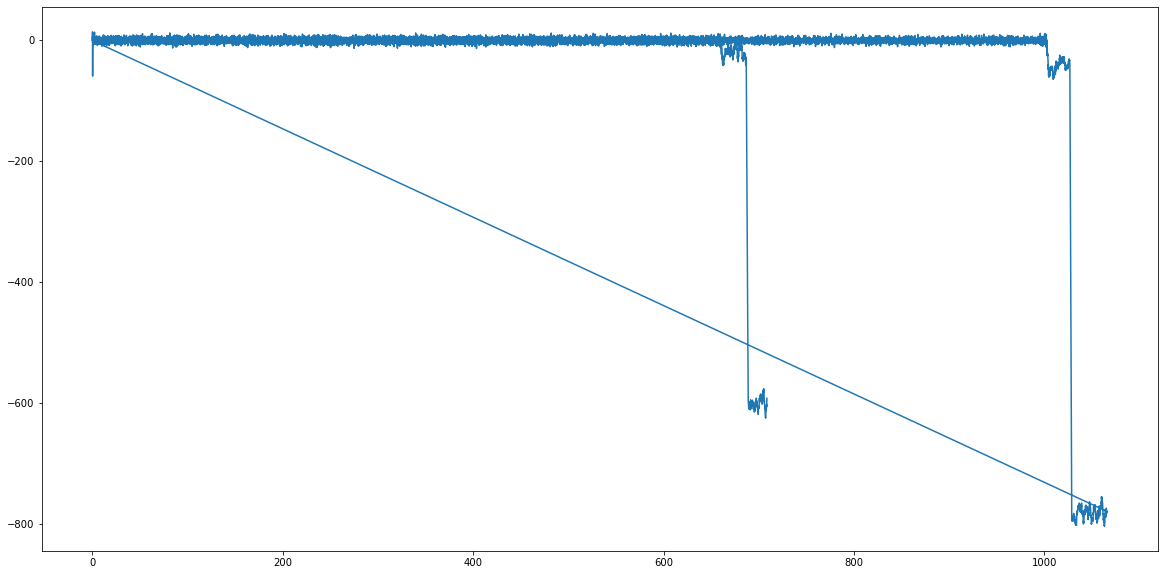

In [4]:
# Creating list of files names to pass to function to download from s3 bucket (in case we want to list multiple simulations)
file_names = ["Stall_Data_2.csv"]

# Passing the bucket, dataset location and file_name list to download from s3 function 
download_from_s3_new(bucket, dataset_location, file_names)

# Creating dictionary elements of filenames and their corresponding dataframes (might be useful if we want to loop multiple files)
flight_data_dict = {i: pd.read_csv(i) for i in file_names}

# Verifying that the file we want is present (in this case we are looking for the dataframe with filename: 'Stall_Data_2.csv' )
flight_data = flight_data_dict['Stall_Data_2.csv']
flight_data.head()

# Plotting out chosen feature against time 
feature = 'cur_avg_vertical_speed'
time = 'cur_time'
plt.figure(figsize=(20,10))
plt.plot(flight_data[time], flight_data[feature])



In [5]:
# Prepare json file for use in DeepAR algorithm 
def prep_json_file(file_name, start_datetime, datalist):
    # Build json data object 
    json_data = [{
        'start': str(start_datetime),
        'target': list(datalist)
    }]
    # Write to json file with \n specifying it as jsonlines and encoding of utf-8
    with open(f"{file_name}.json", 'w', encoding='utf-8') as outfile:
        for entry in json_data:
            json.dump(entry, outfile)
            outfile.write('\n')

# Writing json results to s3 bucket 
def write_to_s3_json (file_name, bucket, file_location):
    s3 = boto3.client('s3')
    s3.upload_file(f"{file_name}.json", bucket, f"{file_location}/{file_name}.json")
    

In [6]:
# Name of training and test files 
file_name_train = 'train_data'
file_name_test = 'test_data'

# Hyperparameters for model and data set splitting 
start_datetime = '2019-07-13 00:00:00'

# Determining prediction length 
prediction_time = 30  # Prediction length in seconds 
data_time_step = 0.1  # Time step of data (between points is 0.1s)
prediction_length = round((prediction_time/data_time_step)) # Number of data points in future to forecast 

# Converting prediction_length to minutes 
#prediction_time_min = round(prediction_length*(10)*(1/60))
#prediction_time_min

context_length = prediction_length # Setting context length equal to prediction

df = flight_data['cur_avg_vertical_speed']

train_data = df.drop(df.tail(prediction_length).index)

test_data = df

print(f"Dataset dimensions: {df.shape}")
print(f"Training set dimensions: {train_data.shape}")
print(f"Test set dimensions: {test_data.shape}")

prep_json_file(file_name_train, start_datetime, train_data.to_list())

Dataset dimensions: (17747,)
Training set dimensions: (17447,)
Test set dimensions: (17747,)


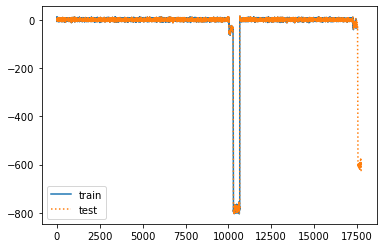

In [7]:
# Plotting test and training sets 
train_data.plot(label='train')
test_data.plot(label='test', ls=":")
plt.legend()
plt.show()

In [8]:
# Writing training results to s3 bucket 
write_to_s3_json(file_name_train, bucket, train_input)

# Writing testing results to s3 bucket 
write_to_s3_json(file_name_test, bucket, test_input)


In [9]:
# Importing DeepAR Algorithm Image 
from sagemaker.amazon.amazon_estimator import get_image_uri
image_uri = sagemaker.image_uris.retrieve("forecasting-deepar", boto3.Session().region_name)

In [10]:
# Setting estimator and hyperparameters 

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_uri,
    role=execution_role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    base_job_name="Deepar-job",
    output_path=f"s3://{data_output}"
)

hyperparameters = {
    "time_freq": "1M",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10",
}

estimator.set_hyperparameters(**hyperparameters)

In [11]:
# Building data channels for DeepAR (where test and training sets are located)
train_location = f"s3://{bucket}/{train_input}" # Where training data is located 
test_location = f"s3://{bucket}/{test_input}" # Where to store output 

# Currently using only train_lication as there is an error with test_location
data_channels = {"train": train_location}

# Show data channels 
data_channels


{'train': 's3://sagemaker-us-east-1-981537519177/sagemaker/DeepAR/data/train'}

In [100]:
# Training DeepAR Algorithm 
estimator.fit(inputs=data_channels)

2021-07-20 01:26:21 Starting - Starting the training job...
2021-07-20 01:26:49 Starting - Launching requested ML instancesProfilerReport-1626744381: InProgress
...
2021-07-20 01:27:20 Starting - Preparing the instances for training...............
2021-07-20 01:29:52 Downloading - Downloading input data
2021-07-20 01:29:52 Training - Training image download completed. Training in progress..Arguments: train
[07/20/2021 01:29:56 INFO 139777514993024] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.

UnexpectedStatusException: Error for Training job Deepar-job-2021-07-20-01-26-21-153: Failed. Reason: ClientError: Timestamp in series is out of bounds.
Currently, only timestamps between 1677-09-21 and 2262-04-11 are supported in DeepAR. (caused by OutOfBoundsDatetime)

Caused by: Out of bounds nanosecond timestamp: 2768-11-30 00:00:00

In [ ]:
# Deploying endpoint 
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name = job_name,
    initial_instance_count = 1,
    instance_type ='ml.m4.xlarge',
    image_uri = image_uri,
    role = role
)

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings. 

Class taken from AWS Sagemaker Notebook for DeepAR

In [ ]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.

        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points

        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length

    def predict(
        self,
        ts,
        cat=None,
        encoding="utf-8",
        num_samples=100,
        quantiles=["0.1", "0.5", "0.9"],
        content_type="application/json",
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1] + pd.Timedelta(1, unit=self.freq) for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req, initial_args={"ContentType": content_type})
        return self.__decode_response(res, prediction_times, encoding)

    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles"],
            "quantiles": quantiles,
        }
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)

    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(
                start=prediction_times[k], freq=self.freq, periods=self.prediction_length
            )
            list_of_df.append(
                pd.DataFrame(
                    data=response_data["predictions"][k]["quantiles"], index=prediction_index
                )
            )
        return list_of_df

In [ ]:
predictor = DeepARPredictor(endpoint_name=endpoint_name, sagemaker_session=sagemaker_session)
predictor.set_prediction_parameters(freq, prediction_length)

In [ ]:
# Deleting endpoint when no longer used 
sagemaker_session.delete_endpoint(endpoint_name)